In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt



# Path to the data directory
base_path = r"C:\Users\Simon\Documents\Vs-kode\IKT450-Project\data"

# Load feature names and activity labels
features = pd.read_csv(f"{base_path}/features.txt", sep="\s+", header=None, names=["index", "feature_name"])
activity_labels = pd.read_csv(f"{base_path}/activity_labels.txt", sep="\s+", header=None, names=["activity_id", "activity_name"])

duplicates = features[features.duplicated('feature_name', keep=False)]

# the features has duplicates, so we need to add unique identifiers to the features
features['unique_feature_name'] = features['feature_name'] + "_" + features.groupby('feature_name').cumcount().astype(str)
feature_names = features["unique_feature_name"].values

# Load test and train data
X_train = pd.read_csv(f"{base_path}/train/X_train.txt", sep="\s+", header=None, names=feature_names)
X_test = pd.read_csv(f"{base_path}/test/X_test.txt", sep="\s+", header=None, names=feature_names)
y_train = pd.read_csv(f"{base_path}/train/y_train.txt", header=None, names=["activity_id"])
y_test = pd.read_csv(f"{base_path}/test/y_test.txt", header=None, names=["activity_id"])

# Adjust y labels to start from 0 (so 1 becomes 0, 2 becomes 1, ..., 6 becomes 5)
y_train['activity_id'] = y_train['activity_id'] - 1
y_test['activity_id'] = y_test['activity_id'] - 1
activity_labels['activity_id'] = activity_labels['activity_id'] - 1

features.head()

,index,feature_name,unique_feature_name
0,1,tBodyAcc-mean()-X,tBodyAcc-mean()-X_0
1,2,tBodyAcc-mean()-Y,tBodyAcc-mean()-Y_0
2,3,tBodyAcc-mean()-Z,tBodyAcc-mean()-Z_0
3,4,tBodyAcc-std()-X,tBodyAcc-std()-X_0
4,5,tBodyAcc-std()-Y,tBodyAcc-std()-Y_0


In [8]:
# Dataset summary
print("Training Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)
print("Features Shape:", features.shape)
print("Activity Labels Shape:", activity_labels.shape)

print("\nTotal Number of Features:", features.shape[0])
print("Total Number of Activities:", activity_labels.shape[0])

# Print the activity labels with both activity_id and activity_name
print("\nActivity_id/label:")
for index, row in activity_labels.iterrows():
    print(f"{row['activity_id']}: {row['activity_name']}")

print("\nTotal Number of Training Samples:", X_train.shape[0])
print("Total Number of Test Samples:", X_test.shape[0])
print("Total Number of entries in the dataset:", X_train.shape[0] + X_test.shape[0])

# Check for missing values
print("\nMissing values in Training Data:", X_train.isnull().sum().sum())
print("Missing values in Test Data:", X_test.isnull().sum().sum())

# Print the percentage of training and testing data
train_percentage = round(X_train.shape[0] / (X_train.shape[0] + X_test.shape[0]), 3)
test_percentage = round(X_test.shape[0] / (X_train.shape[0] + X_test.shape[0]), 3)

print("\nTraining part of dataset:", train_percentage)
print("Testing part of dataset:", test_percentage)

Training Data Shape: (7352, 561)
Test Data Shape: (2947, 561)
Features Shape: (561, 3)
Activity Labels Shape: (6, 2)

Total Number of Features: 561
Total Number of Activities: 6

Activity_id/label:
0: WALKING
1: WALKING_UPSTAIRS
2: WALKING_DOWNSTAIRS
3: SITTING
4: STANDING
5: LAYING

Total Number of Training Samples: 7352
Total Number of Test Samples: 2947
Total Number of entries in the dataset: 10299

Missing values in Training Data: 0
Missing values in Test Data: 0

Training part of dataset: 0.714
Testing part of dataset: 0.286


In [ ]:
# View the first few rows of the training data
print(X_train.head())

   tBodyAcc-mean()-X_0  tBodyAcc-mean()-Y_0  tBodyAcc-mean()-Z_0  \
0             0.288585            -0.020294            -0.132905   
1             0.278419            -0.016411            -0.123520   
2             0.279653            -0.019467            -0.113462   
3             0.279174            -0.026201            -0.123283   
4             0.276629            -0.016570            -0.115362   

   tBodyAcc-std()-X_0  tBodyAcc-std()-Y_0  tBodyAcc-std()-Z_0  \
0           -0.995279           -0.983111           -0.913526   
1           -0.998245           -0.975300           -0.960322   
2           -0.995380           -0.967187           -0.978944   
3           -0.996091           -0.983403           -0.990675   
4           -0.998139           -0.980817           -0.990482   

   tBodyAcc-mad()-X_0  tBodyAcc-mad()-Y_0  tBodyAcc-mad()-Z_0  \
0           -0.995112           -0.983185           -0.923527   
1           -0.998807           -0.974914           -0.957686   
2    

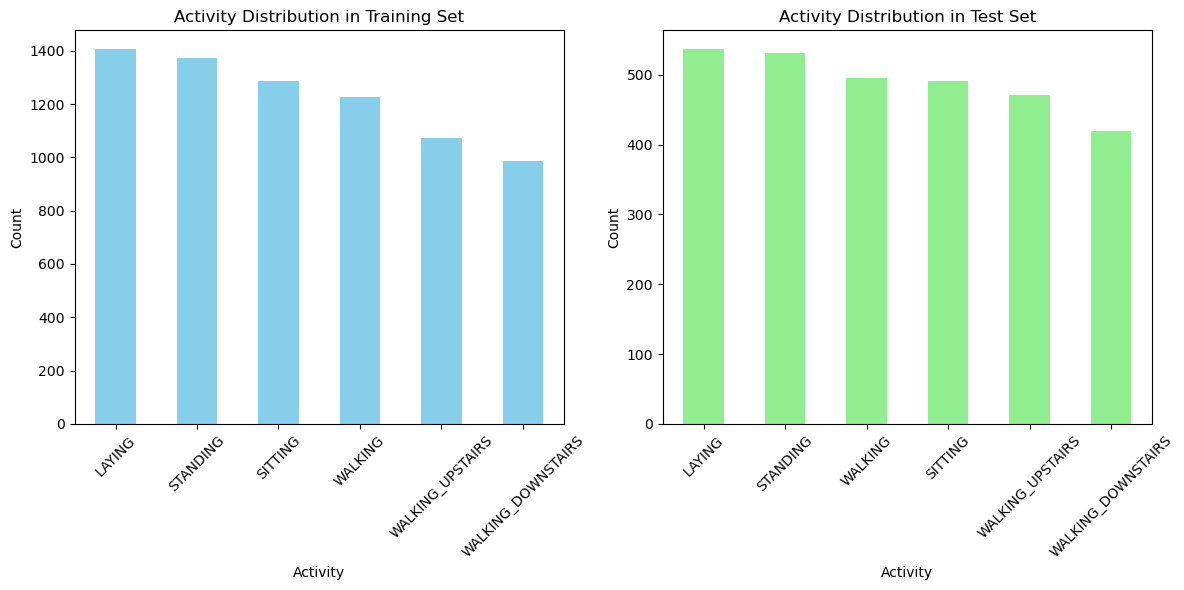

In [11]:
# Count occurrences of each activity in training and test sets
activity_counts_train = y_train['activity_id'].value_counts()
activity_counts_test = y_test['activity_id'].value_counts()

# Map activity IDs to activity names for readability
activity_names = activity_labels.set_index('activity_id')['activity_name']
activity_counts_train.index = activity_counts_train.index.map(activity_names)
activity_counts_test.index = activity_counts_test.index.map(activity_names)

# Plot the distribution of activities in training and test sets
plt.figure(figsize=(12, 6))

# Training set distribution
plt.subplot(1, 2, 1)
activity_counts_train.plot(kind='bar', color='skyblue')
plt.title('Activity Distribution in Training Set')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Test set distribution
plt.subplot(1, 2, 2)
activity_counts_test.plot(kind='bar', color='lightgreen')
plt.title('Activity Distribution in Test Set')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

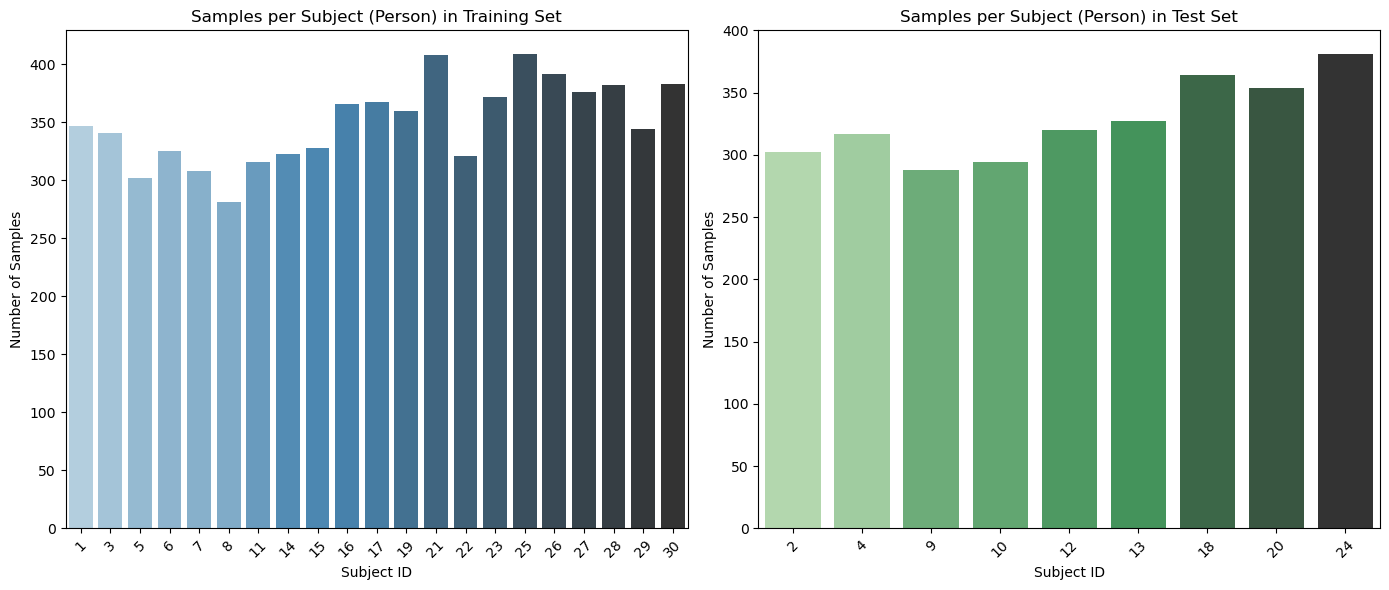

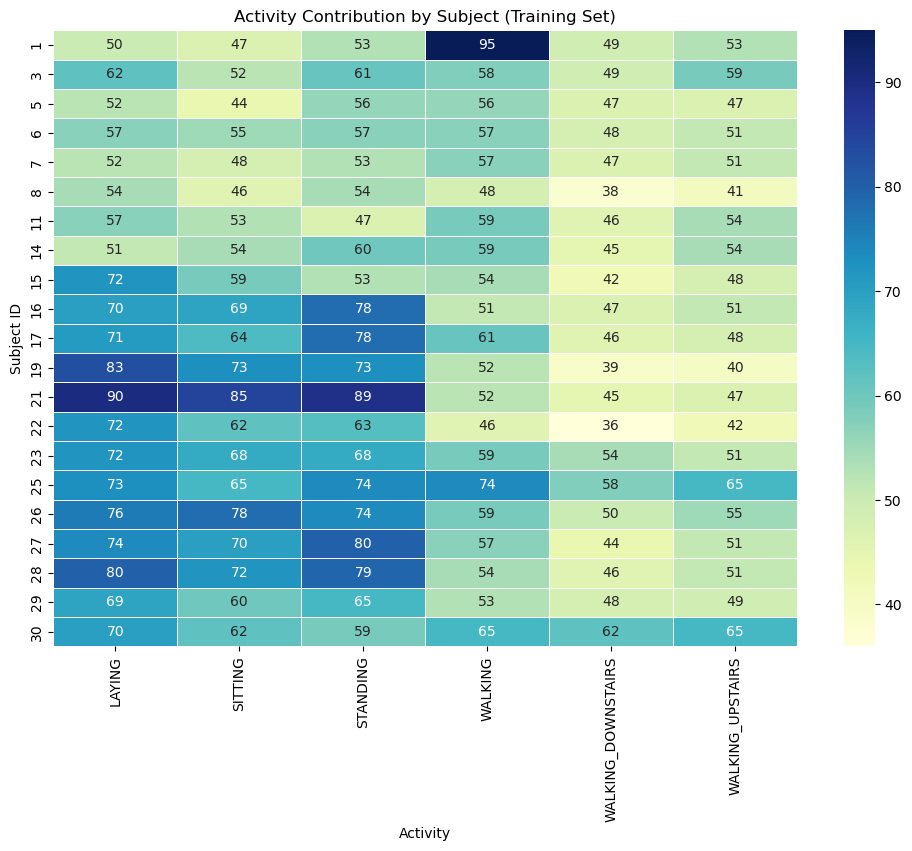

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load subject data for training and test sets
subject_train = pd.read_csv(f"{base_path}/train/subject_train.txt", header=None, names=["subject_id"])
subject_test = pd.read_csv(f"{base_path}/test/subject_test.txt", header=None, names=["subject_id"])

# Combine subject and activity data for analysis
subject_train['activity_id'] = y_train['activity_id']
subject_test['activity_id'] = y_test['activity_id']

# Count the number of samples per subject in training and test sets
train_subject_counts = subject_train['subject_id'].value_counts().sort_index()
test_subject_counts = subject_test['subject_id'].value_counts().sort_index()

# Visualize the distribution of samples across subjects for training and test sets
plt.figure(figsize=(14, 6))

# Training set distribution
plt.subplot(1, 2, 1)
sns.barplot(
    x=train_subject_counts.index,
    y=train_subject_counts.values,
    hue=train_subject_counts.index,
    dodge=False,  # Avoid separation caused by hue
    palette="Blues_d",
    legend=False
)
plt.title("Samples per Subject (Person) in Training Set")
plt.xlabel("Subject ID")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

# Test set distribution
plt.subplot(1, 2, 2)
sns.barplot(
    x=test_subject_counts.index,
    y=test_subject_counts.values,
    hue=test_subject_counts.index,
    dodge=False,  # Avoid separation caused by hue
    palette="Greens_d",
    legend=False
)
plt.title("Samples per Subject (Person) in Test Set")
plt.xlabel("Subject ID")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analyze activities per subject
train_subject_activities = subject_train.groupby('subject_id')['activity_id'].unique()
test_subject_activities = subject_test.groupby('subject_id')['activity_id'].unique()

# Create a summary DataFrame for activities per subject
subject_activity_counts = subject_train.groupby(['subject_id', 'activity_id']).size().reset_index(name='count')
subject_activity_counts['activity_name'] = subject_activity_counts['activity_id'].map(activity_names)

# Create pivot table for heatmap
pivot_data = subject_activity_counts.pivot(index="subject_id", columns="activity_name", values="count")

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)
plt.title("Activity Contribution by Subject (Training Set)")
plt.xlabel("Activity")
plt.ylabel("Subject ID")
plt.show()


## Splitting the training set, to a validation and training set ( keeping the original test set) ## 

In [10]:
from sklearn.model_selection import train_test_split

# Split original training data into training and validation data
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Opsummer datasættets form
print("Training Data Shape:", X_train_new.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

# Beregn totale antal prøver
total_samples = X_train_new.shape[0] + X_val.shape[0] + X_test.shape[0]

# Udskriv detaljer om datasætfordelingen
print("\nTotal Number of Training Samples:", X_train_new.shape[0])
print("Total Number of Validation Samples:", X_val.shape[0])
print("Total Number of Test Samples:", X_test.shape[0])
print("Total Number of Entries:", total_samples)

# Procentvis fordeling
train_percentage = round(X_train_new.shape[0] / total_samples, 3)
val_percentage = round(X_val.shape[0] / total_samples, 3)
test_percentage = round(X_test.shape[0] / total_samples, 3)

print("\nTraining part of dataset:", train_percentage)
print("Validation part of dataset:", val_percentage)
print("Testing part of dataset:", test_percentage)


Training Data Shape: (5881, 561)
Validation Data Shape: (1471, 561)
Test Data Shape: (2947, 561)

Total Number of Training Samples: 5881
Total Number of Validation Samples: 1471
Total Number of Test Samples: 2947
Total Number of Entries: 10299

Training part of dataset: 0.571
Validation part of dataset: 0.143
Testing part of dataset: 0.286


In [ ]:
# Look at the descriptive statistics of the training data
X_train_new.describe()

,tBodyAcc-mean()-X_0,tBodyAcc-mean()-Y_0,tBodyAcc-mean()-Z_0,tBodyAcc-std()-X_0,tBodyAcc-std()-Y_0,tBodyAcc-std()-Z_0,tBodyAcc-mad()-X_0,tBodyAcc-mad()-Y_0,tBodyAcc-mad()-Z_0,tBodyAcc-max()-X_0,...,fBodyBodyGyroJerkMag-meanFreq()_0,fBodyBodyGyroJerkMag-skewness()_0,fBodyBodyGyroJerkMag-kurtosis()_0,"angle(tBodyAccMean,gravity)_0","angle(tBodyAccJerkMean),gravityMean)_0","angle(tBodyGyroMean,gravityMean)_0","angle(tBodyGyroJerkMean,gravityMean)_0","angle(X,gravityMean)_0","angle(Y,gravityMean)_0","angle(Z,gravityMean)_0"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274167,-0.017336,-0.108940,-0.606178,-0.509468,-0.603622,-0.631329,-0.525378,-0.604849,-0.468170,...,0.123418,-0.305685,-0.624077,0.011141,0.001113,0.009535,-0.009275,-0.489741,0.060096,-0.056143
std,0.069851,0.042571,0.058213,0.447358,0.504049,0.419471,0.422430,0.487419,0.415109,0.544721,...,0.251343,0.321061,0.307470,0.335056,0.446215,0.607482,0.477085,0.512228,0.297258,0.279889
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-0.999879,-1.000000,...,-0.965725,-0.995357,-0.999765,-0.975745,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.263073,-0.024564,-0.120992,-0.992748,-0.977544,-0.980020,-0.993596,-0.977698,-0.979907,-0.936232,...,-0.026380,-0.542828,-0.845186,-0.118186,-0.292016,-0.484426,-0.378560,-0.813626,-0.014784,-0.141555
50%,0.277184,-0.017182,-0.108640,-0.946750,-0.853679,-0.858729,-0.950850,-0.856916,-0.855078,-0.882797,...,0.130831,-0.341518,-0.709716,0.009849,0.007797,0.014503,-0.004716,-0.709320,0.182775,0.003162
75%,0.287818,-0.010376,-0.097624,-0.245491,-0.031452,-0.258825,-0.297141,-0.063945,-0.261744,-0.017129,...,0.285913,-0.122343,-0.500354,0.155218,0.286186,0.504529,0.356263,-0.508282,0.249405,0.107047
max,1.000000,1.000000,1.000000,0.876942,0.873037,1.000000,0.852822,0.967664,1.000000,0.907994,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [17]:
# Define paths to save the datasets
output_path = r"C:\Users\Simon\Documents\Vs-kode\IKT450-Project\processed_data"
os.makedirs(output_path, exist_ok=True)

# Save datasets as Pickle files
X_train_new.to_pickle(f"{output_path}/X_train.pkl")
y_train_new.to_pickle(f"{output_path}/y_train.pkl")

X_val.to_pickle(f"{output_path}/X_val.pkl")
y_val.to_pickle(f"{output_path}/y_val.pkl")

X_test.to_pickle(f"{output_path}/X_test.pkl")
y_test.to_pickle(f"{output_path}/y_test.pkl")

print("Datasets successfully saved as Pickle files!")


Datasets successfully saved as Pickle files!
